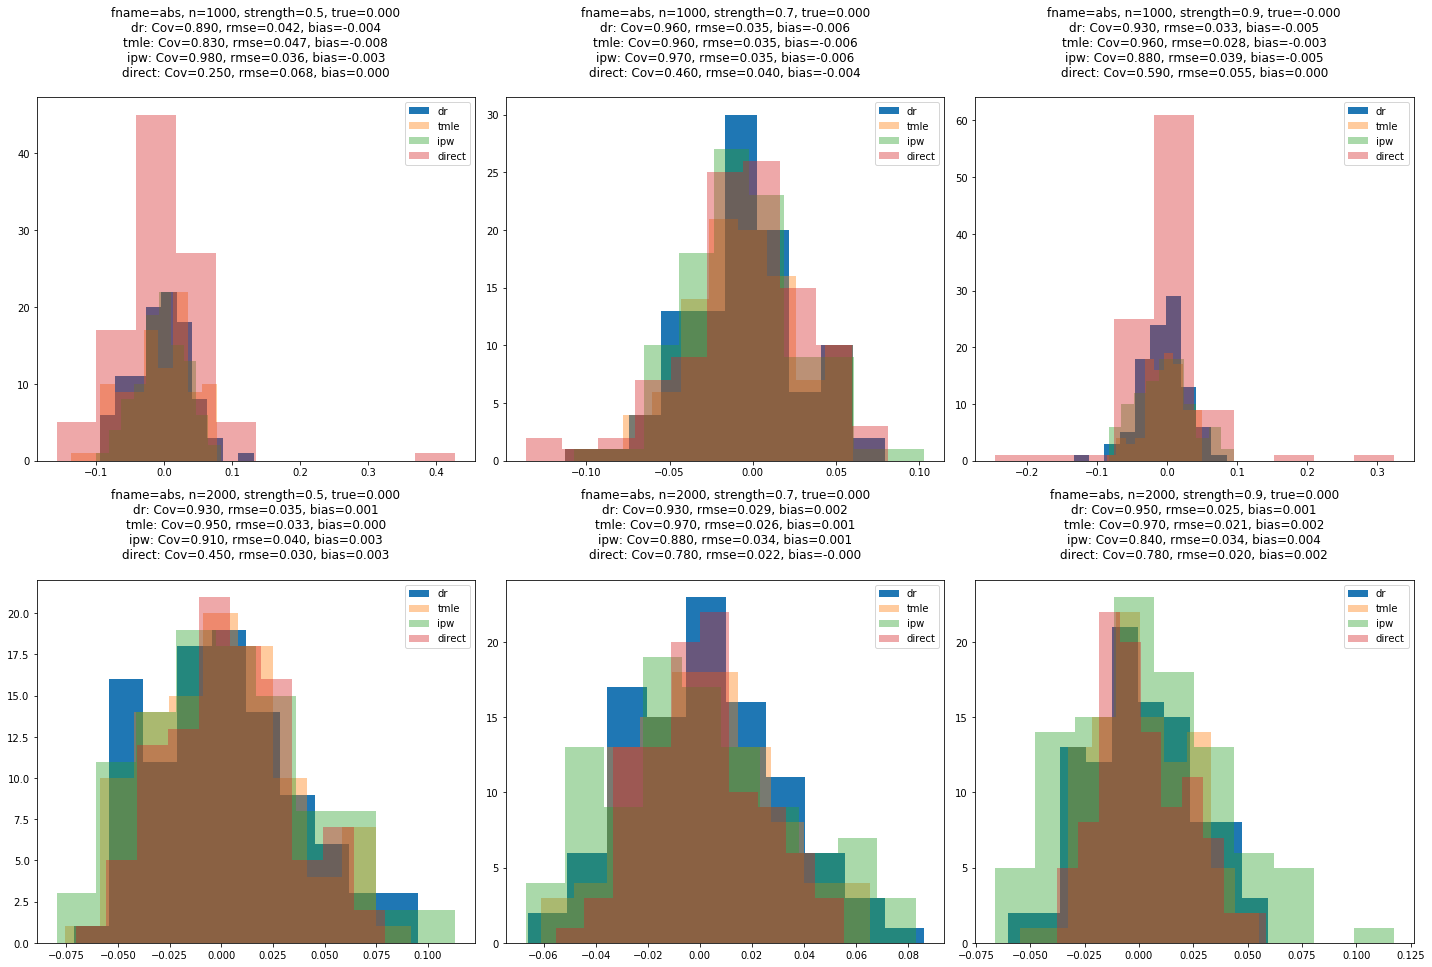

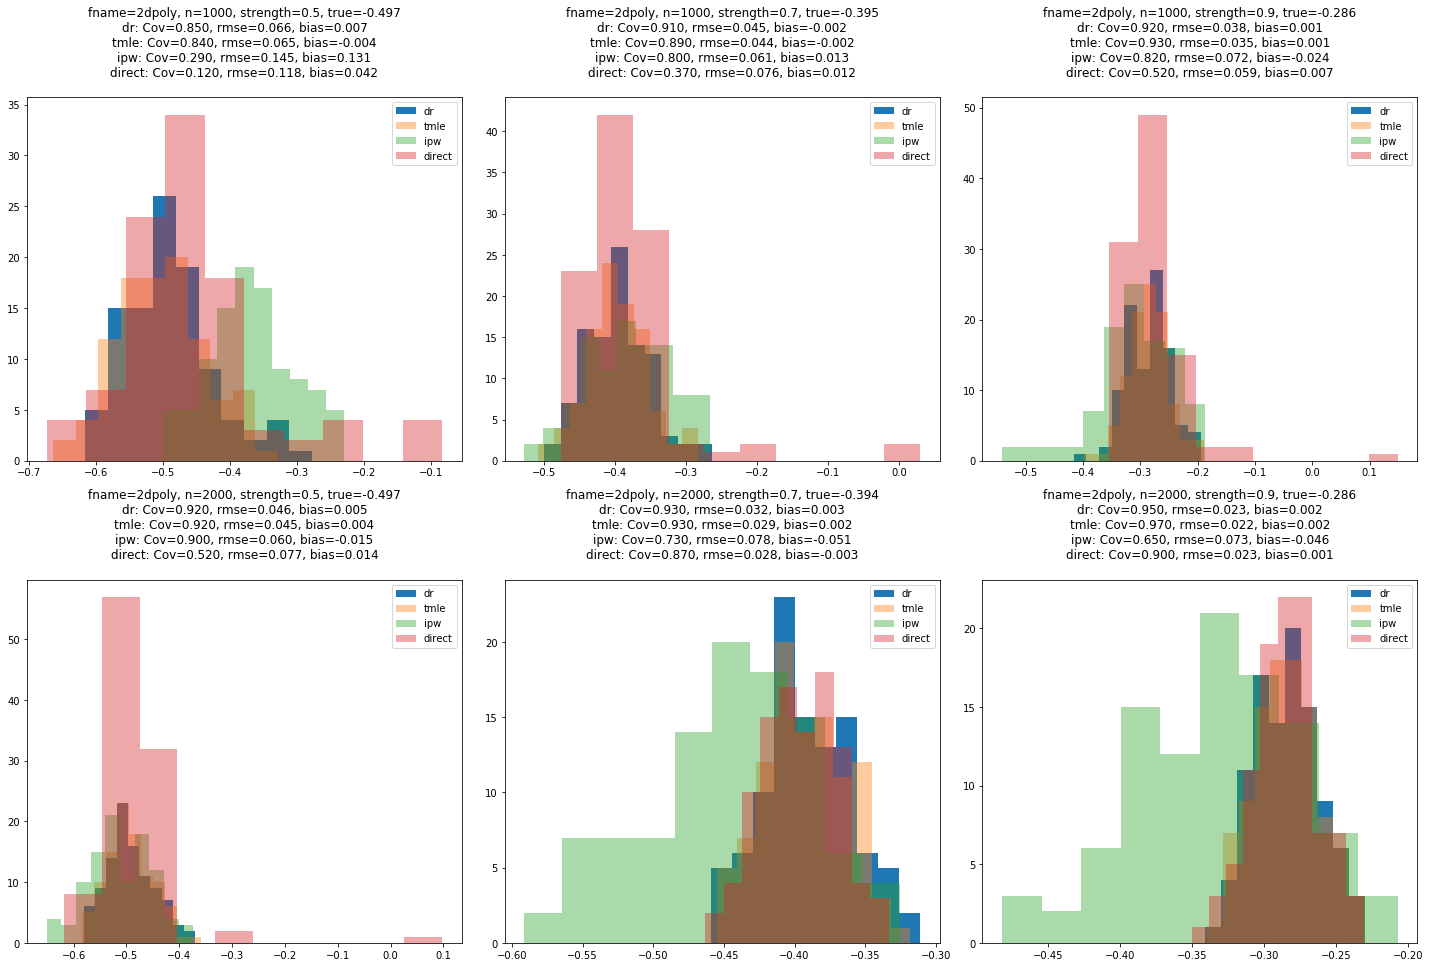

In [9]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor
import joblib

def plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true):
    plt.title(f'fname={fname}, n={n}, strength={iv_strength}, true={true:.3f}\n'
              f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()


n_z = 1
n_t = 1
dgp_num = 5
epsilon = 0.1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)

for fname in ['abs', '2dpoly']:
    plt.figure(figsize=(20, 20))
    it = 1
    for n in [1000, 2000]:
        for iv_strength in [.5, .7, .9]:
            plt.subplot(3, 3, it)
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}.jbl')
            dr = np.array([r[0] for r in results])
            tmle = np.array([r[1] for r in results])
            ipw = np.array([r[2] for r in results])
            direct = np.array([r[3] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1
    plt.tight_layout()
    plt.show()

In [57]:
import pandas as pd

resd = {}
for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
    resd[fname] = {}
    for n in [1000, 2000]:
        nkey = f'$n={n}$'
        resd[fname][nkey] = {}
        for iv_strength in [.5, .7, .9]:
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}.jbl')
            ivkey = f'$\rho={iv_strength}$'
            resd[fname][nkey][ivkey] = {}
            for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                data = np.array([r[it] for r in results])
                if method in ['dr', 'tmle']:
                    cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                else:
                    cov = 'NA'
                resd[fname][nkey][ivkey][method] = {
                                'cov': cov,
                                'rmse': f'{np.sqrt(np.mean((data[:, 0]-true)**2)):.3f}',
                                'bias': f'{np.abs(np.mean((data[:, 0]-true))):.3f}'}
            resd[fname][nkey][ivkey] = pd.DataFrame(resd[fname][nkey][ivkey])
        resd[fname][nkey] = pd.concat(resd[fname][nkey])
    resd[fname] = pd.concat(resd[fname])

display(pd.concat(resd).unstack(level=3))
print(pd.concat(resd).unstack(level=3).to_latex(bold_rows=True, multirow=True,
                                                multicolumn=True, escape=False))

dr               tmle               ipw         \
                            cov   rmse   bias  cov   rmse   bias cov   rmse   
abs     $n=1000$ $\rho=0.5$  89  0.042  0.004   83  0.047  0.008  NA  0.036   
                 $\rho=0.7$  96  0.035  0.006   96  0.035  0.006  NA  0.035   
                 $\rho=0.9$  93  0.033  0.005   96  0.028  0.003  NA  0.039   
        $n=2000$ $\rho=0.5$  93  0.035  0.001   95  0.033  0.000  NA  0.040   
                 $\rho=0.7$  93  0.029  0.002   97  0.026  0.001  NA  0.034   
                 $\rho=0.9$  95  0.025  0.001   97  0.021  0.002  NA  0.034   
2dpoly  $n=1000$ $\rho=0.5$  85  0.066  0.007   84  0.065  0.004  NA  0.145   
                 $\rho=0.7$  91  0.045  0.002   89  0.044  0.002  NA  0.061   
                 $\rho=0.9$  92  0.038  0.001   93  0.035  0.001  NA  0.072   
        $n=2000$ $\rho=0.5$  92  0.046  0.005   92  0.045  0.004  NA  0.060   
                 $\rho=0.7$  93  0.032  0.003   93  0.029  0.002  NA  0.078   
                 $\rho=0.9$  95  0.023  0.002   97  0.022  0.002  NA  0.073   
sigmoid $n=1000$ $\rho=0.5$  87  0.033  0.003   80  0.036  0.002  NA  0.063   
                 $\rho=0.7$  95  0.026  0.001   95  0.026  0.001  NA  0.032   
                 $\rho=0.9$  96  0.024  0.001   96  0.023  0.001  NA  0.039   
        $n=2000$ $\rho=0.5$  93  0.027  0.002   96  0.025  0.001  NA  0.039   
                 $\rho=0.7$  95  0.020  0.001   98  0.019  0.001  NA  0.040   
                 $\rho=0.9$  95  0.021  0.000   99  0.016  0.000  NA  0.050   
sin     $n=1000$ $\rho=0.5$  85  0.036  0.002   78  0.037  0.003  NA  0.051   
                 $\rho=0.7$  87  0.033  0.010   91  0.028  0.009  NA  0.036   
                 $\rho=0.9$  95  0.029  0.005   95  0.028  0.006  NA  0.031   
        $n=2000$ $\rho=0.5$  95  0.026  0.004   96  0.024  0.003  NA  0.034   
                 $\rho=0.7$  94  0.020  0.003   96  0.018  0.004  NA  0.034   
                 $\rho=0.9$  94  0.022  0.003   97  0.018  0.000  NA  0.031   

                                   direct                
                              bias    cov   rmse   bias  
abs     $n=1000$ $\rho=0.5$  0.003     NA  0.068  0.000  
                 $\rho=0.7$  0.006     NA  0.040  0.004  
                 $\rho=0.9$  0.005     NA  0.055  0.000  
        $n=2000$ $\rho=0.5$  0.003     NA  0.030  0.003  
                 $\rho=0.7$  0.001     NA  0.022  0.000  
                 $\rho=0.9$  0.004     NA  0.020  0.002  
2dpoly  $n=1000$ $\rho=0.5$  0.131     NA  0.118  0.042  
                 $\rho=0.7$  0.013     NA  0.076  0.012  
                 $\rho=0.9$  0.024     NA  0.059  0.007  
        $n=2000$ $\rho=0.5$  0.015     NA  0.077  0.014  
                 $\rho=0.7$  0.051     NA  0.028  0.003  
                 $\rho=0.9$  0.046     NA  0.023  0.001  
sigmoid $n=1000$ $\rho=0.5$  0.053     NA  0.042  0.009  
                 $\rho=0.7$  0.006     NA  0.028  0.002  
                 $\rho=0.9$  0.014     NA  0.035  0.001  
        $n=2000$ $\rho=0.5$  0.011     NA  0.054  0.010  
                 $\rho=0.7$  0.028     NA  0.019  0.007  
                 $\rho=0.9$  0.038     NA  0.026  0.001  
sin     $n=1000$ $\rho=0.5$  0.038     NA  0.048  0.002  
                 $\rho=0.7$  0.007     NA  0.048  0.004  
                 $\rho=0.9$  0.015     NA  0.044  0.011  
        $n=2000$ $\rho=0.5$  0.011     NA  0.026  0.007  
                 $\rho=0.7$  0.024     NA  0.026  0.017  
                 $\rho=0.9$  0.021     NA  0.028  0.015

\begin{tabular}{lllllllllllllll}
\toprule
    &          &            & \multicolumn{3}{l}{dr} & \multicolumn{3}{l}{tmle} & \multicolumn{3}{l}{ipw} & \multicolumn{3}{l}{direct} \\
    &          &            & cov &   rmse &   bias &  cov &   rmse &   bias & cov &   rmse &   bias &    cov &   rmse &   bias \\
\midrule
\multirow{6}{*}{\textbf{abs}} & \multirow{3}{*}{\textbf{$n=1000$}} & \textbf{$\rho=0.5$} &  89 &  0.042 &  0.004 &   83 &  0.047 &  0.008 &  NA &  0.036 &  0.003 &     NA &  0.068 &  0.000 \\
    &          & \textbf{$\rho=0.7$} &  96 &  0.035 &  0.006 &   96 &  0.035 &  0.006 &  NA &  0.035 &  0.006 &     NA &  0.040 &  0.004 \\
    &          & \textbf{$\rho=0.9$} &  93 &  0.033 &  0.005 &   96 &  0.028 &  0.003 &  NA &  0.039 &  0.005 &     NA &  0.055 &  0.000 \\
\cline{2-15}
    & \multirow{3}{*}{\textbf{$n=2000$}} & \textbf{$\rho=0.5$} &  93 &  0.035 &  0.001 &   95 &  0.033 &  0.000 &  NA &  0.040 &  0.003 &     NA &  0.030 &  0.003 \\
    &          & \textbf{$\rh

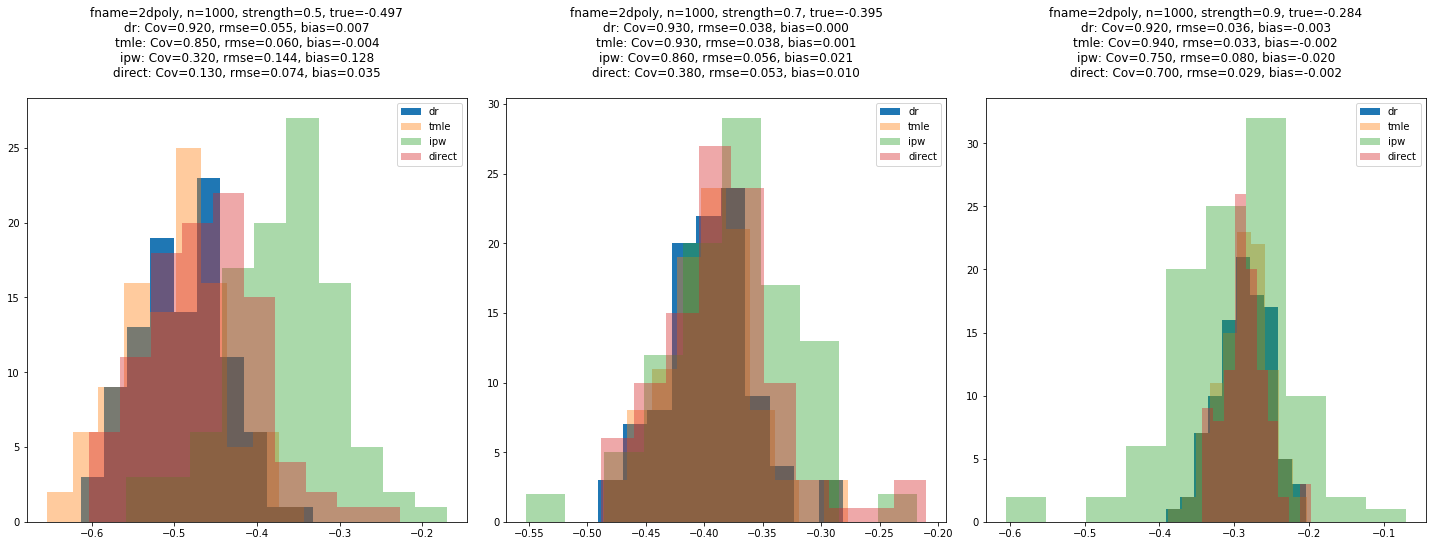

In [52]:
clever = True
for fname in ['2dpoly']:
    plt.figure(figsize=(20, 20))
    it = 1
#     for n in [1000, 2000]:
    for n in [1000]:
        for iv_strength in [.5, .7, .9]:
            plt.subplot(3, 3, it)
            # true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}.jbl')
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}_clever_{clever}.jbl')
            dr = np.array([r[0] for r in results])
            tmle = np.array([r[1] for r in results])
            ipw = np.array([r[2] for r in results])
            direct = np.array([r[3] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1
    plt.tight_layout()
    plt.show()

In [56]:
import pandas as pd

clever = True
resd = {}
for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
    resd[fname] = {}
    for n in [500, 1000]:
        nkey = f'$n={n}$'
        resd[fname][nkey] = {}
        for iv_strength in [.5, .7, .9]:
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}_clever_{clever}.jbl')
            ivkey = f'$\rho={iv_strength}$'
            resd[fname][nkey][ivkey] = {}
            for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                data = np.array([r[it] for r in results])
                if method in ['dr', 'tmle']:
                    cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                else:
                    cov = 'NA'
                resd[fname][nkey][ivkey][method] = {
                                'cov': cov,
                                'rmse': f'{np.sqrt(np.mean((data[:, 0]-true)**2)):.3f}',
                                'bias': f'{np.abs(np.mean((data[:, 0]-true))):.3f}'}
            resd[fname][nkey][ivkey] = pd.DataFrame(resd[fname][nkey][ivkey])
        resd[fname][nkey] = pd.concat(resd[fname][nkey])
    resd[fname] = pd.concat(resd[fname])

display(pd.concat(resd).unstack(level=3))
print(pd.concat(resd).unstack(level=3).to_latex(bold_rows=True, multirow=True,
                                                multicolumn=True, escape=False))

dr               tmle               ipw         \
                            cov   rmse   bias  cov   rmse   bias cov   rmse   
abs     $n=500$  $\rho=0.5$  65  0.064  0.010   59  0.070  0.016  NA  0.032   
                 $\rho=0.7$  86  0.052  0.004   85  0.052  0.007  NA  0.035   
                 $\rho=0.9$  92  0.042  0.001   85  0.043  0.002  NA  0.045   
        $n=1000$ $\rho=0.5$  92  0.040  0.003   83  0.045  0.002  NA  0.036   
                 $\rho=0.7$  98  0.033  0.005   97  0.033  0.006  NA  0.034   
                 $\rho=0.9$  97  0.029  0.005   96  0.026  0.003  NA  0.038   
2dpoly  $n=500$  $\rho=0.5$  56  0.117  0.064   58  0.107  0.006  NA  0.277   
                 $\rho=0.7$  80  0.085  0.022   75  0.086  0.003  NA  0.145   
                 $\rho=0.9$  85  0.056  0.005   86  0.049  0.005  NA  0.090   
        $n=1000$ $\rho=0.5$  92  0.055  0.007   85  0.060  0.004  NA  0.144   
                 $\rho=0.7$  93  0.038  0.000   93  0.038  0.001  NA  0.056   
                 $\rho=0.9$  92  0.036  0.003   94  0.033  0.002  NA  0.080   
sigmoid $n=500$  $\rho=0.5$  70  0.060  0.022   68  0.054  0.007  NA  0.113   
                 $\rho=0.7$  88  0.040  0.001   84  0.041  0.000  NA  0.069   
                 $\rho=0.9$  94  0.032  0.002   90  0.039  0.002  NA  0.047   
        $n=1000$ $\rho=0.5$  83  0.035  0.001   81  0.037  0.001  NA  0.061   
                 $\rho=0.7$  94  0.026  0.001   94  0.026  0.001  NA  0.031   
                 $\rho=0.9$  97  0.022  0.002   97  0.022  0.002  NA  0.038   
sin     $n=500$  $\rho=0.5$  74  0.065  0.011   65  0.062  0.002  NA  0.086   
                 $\rho=0.7$  86  0.037  0.008   81  0.039  0.013  NA  0.045   
                 $\rho=0.9$  87  0.039  0.012   83  0.041  0.015  NA  0.035   
        $n=1000$ $\rho=0.5$  84  0.036  0.004   81  0.038  0.003  NA  0.051   
                 $\rho=0.7$  93  0.028  0.008   92  0.028  0.007  NA  0.032   
                 $\rho=0.9$  98  0.025  0.007   98  0.025  0.007  NA  0.038   

                                   direct                
                              bias    cov   rmse   bias  
abs     $n=500$  $\rho=0.5$  0.007     NA  0.075  0.006  
                 $\rho=0.7$  0.005     NA  0.053  0.004  
                 $\rho=0.9$  0.001     NA  0.042  0.005  
        $n=1000$ $\rho=0.5$  0.000     NA  0.043  0.013  
                 $\rho=0.7$  0.005     NA  0.029  0.001  
                 $\rho=0.9$  0.007     NA  0.028  0.002  
2dpoly  $n=500$  $\rho=0.5$  0.269     NA  0.199  0.134  
                 $\rho=0.7$  0.121     NA  0.127  0.070  
                 $\rho=0.9$  0.037     NA  0.086  0.046  
        $n=1000$ $\rho=0.5$  0.128     NA  0.074  0.035  
                 $\rho=0.7$  0.021     NA  0.053  0.010  
                 $\rho=0.9$  0.020     NA  0.029  0.002  
sigmoid $n=500$  $\rho=0.5$  0.109     NA  0.094  0.036  
                 $\rho=0.7$  0.056     NA  0.048  0.010  
                 $\rho=0.9$  0.016     NA  0.067  0.013  
        $n=1000$ $\rho=0.5$  0.050     NA  0.033  0.000  
                 $\rho=0.7$  0.001     NA  0.027  0.001  
                 $\rho=0.9$  0.013     NA  0.026  0.000  
sin     $n=500$  $\rho=0.5$  0.080     NA  0.077  0.018  
                 $\rho=0.7$  0.024     NA  0.061  0.003  
                 $\rho=0.9$  0.000     NA  0.044  0.001  
        $n=1000$ $\rho=0.5$  0.037     NA  0.036  0.005  
                 $\rho=0.7$  0.004     NA  0.029  0.010  
                 $\rho=0.9$  0.015     NA  0.026  0.009

\begin{tabular}{lllllllllllllll}
\toprule
    &          &            & \multicolumn{3}{l}{dr} & \multicolumn{3}{l}{tmle} & \multicolumn{3}{l}{ipw} & \multicolumn{3}{l}{direct} \\
    &          &            & cov &   rmse &   bias &  cov &   rmse &   bias & cov &   rmse &   bias &    cov &   rmse &   bias \\
\midrule
\multirow{6}{*}{\textbf{abs}} & \multirow{3}{*}{\textbf{$n=500$}} & \textbf{$\rho=0.5$} &  65 &  0.064 &  0.010 &   59 &  0.070 &  0.016 &  NA &  0.032 &  0.007 &     NA &  0.075 &  0.006 \\
    &          & \textbf{$\rho=0.7$} &  86 &  0.052 &  0.004 &   85 &  0.052 &  0.007 &  NA &  0.035 &  0.005 &     NA &  0.053 &  0.004 \\
    &          & \textbf{$\rho=0.9$} &  92 &  0.042 &  0.001 &   85 &  0.043 &  0.002 &  NA &  0.045 &  0.001 &     NA &  0.042 &  0.005 \\
\cline{2-15}
    & \multirow{3}{*}{\textbf{$n=1000$}} & \textbf{$\rho=0.5$} &  92 &  0.040 &  0.003 &   83 &  0.045 &  0.002 &  NA &  0.036 &  0.000 &     NA &  0.043 &  0.013 \\
    &          & \textbf{$\rho